In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
import statsmodels

In [5]:
df = pd.read_excel("Complete Data FINAL.xlsx")
df.isna().sum()


DateTime                      0
System Price                  0
NO1 Price                     0
NO2 Price                     0
NO3 Price                     0
NO4 Price                     0
NO5 Price                     0
SE1 Price                     0
SE2 Price                     0
SE3 Price                     0
SE4 Price                     0
DK1 Price                     0
DK2 Price                     0
FI Price                      0
Total_Volume                  0
Hydro levels NO               0
Hydro levels SE               0
Hydro levels FI               0
Settled wind production SE    0
Settled wind production DK    0
Settled wind production FI    0
Oil                           0
Coal                          0
Gas                           0
Permit                        0
Weekend                       0
Christmas vacation            0
Public holiday                0
Temp NO                       0
Precip NO                     0
Total Consumption             0
Total Pr

## Tests for stationarity 

In [32]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print('Results of Augmented Dickey-Fuller Test:')
    adf_result = adfuller(timeseries)
    
    # Retrieve the p-value
    adf_pvalue = adf_result[1]
    
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_pvalue}')
    
    if adf_pvalue < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print('\nResults of KPSS Test:')
    statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    
    
    if p_value < 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")



In [8]:

adf_test(df["System Price"]) #h0 can be rejected, there is  enough evidence that the timeseries is stationary
kpss_test(df["System Price"]) #h0 can be rejected, there is enough evidence that the timeseries is non-statinoary

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -9.561406900666906
p-value: 2.4203695400863805e-16
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 8.840221205531424
p-value: 0.01
The series is non-stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_82856\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [20]:
adf_test(df_filtered["systemPricelog"].diff().dropna())
kpss_test(df_filtered["systemPricelog"].diff().dropna())

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -18.335945933379826
p-value: 2.2509838808301472e-30
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.0390993276488459
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_57016\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


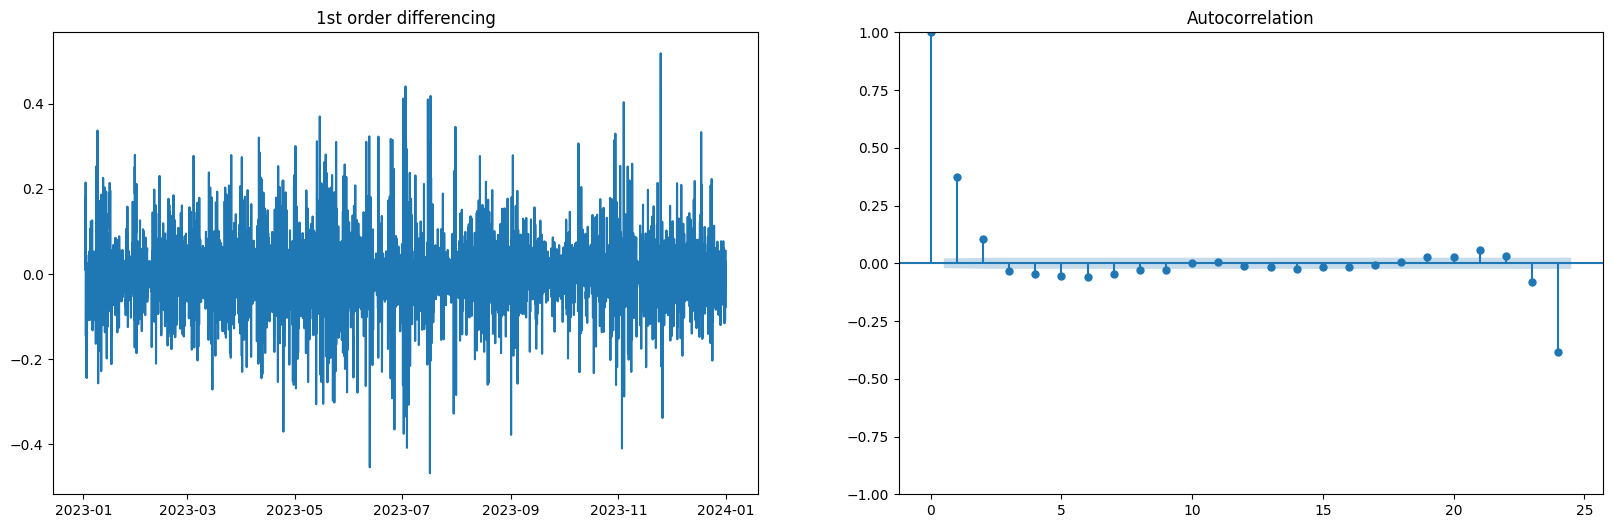

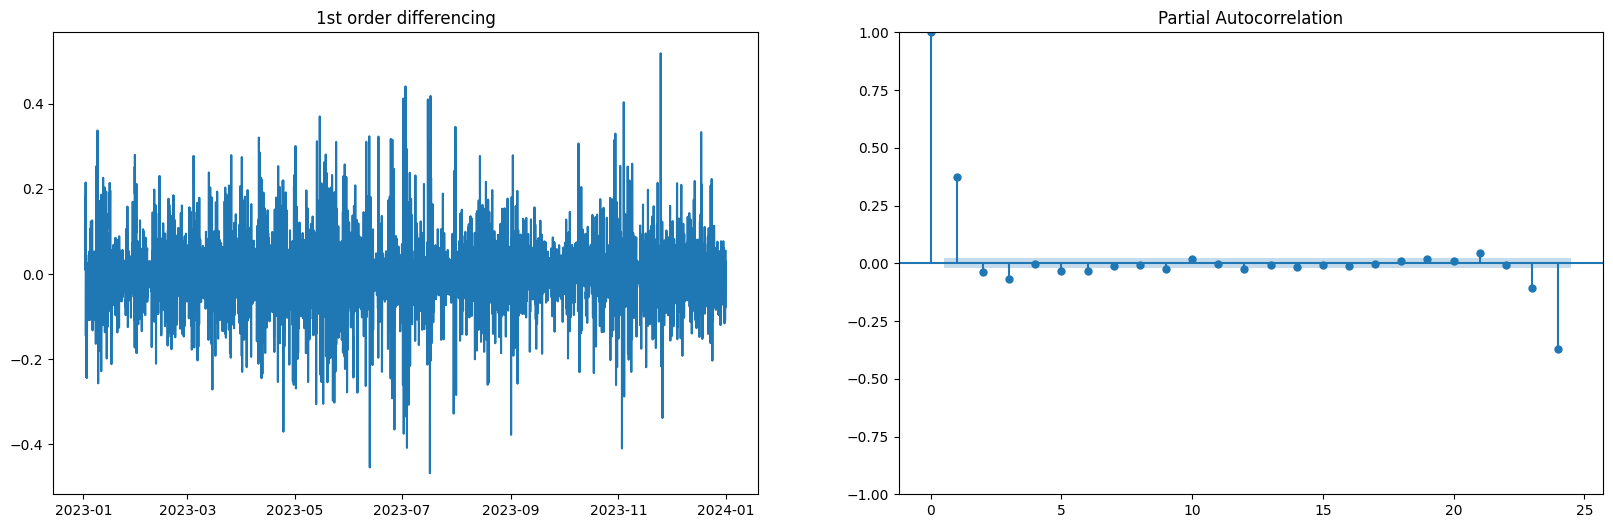

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -23.648761491743336
p-value: 0.0
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.002928921471837624
p-value: 0.1
The series is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_51156\1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [104]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

differenced_data = df_filtered["systemPricelog"].diff().diff(24).dropna()



f = plt.figure(figsize=(20, 6))

# First subplot for the differenced data.
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

# Second subplot for the ACF plot.
ax2 = f.add_subplot(122)
plot_acf(differenced_data, lags=24, ax=ax2)
plt.show()


f = plt.figure(figsize=(20, 6))

ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

ax2 = f.add_subplot(122)
plot_pacf(differenced_data, lags=24, ax=ax2)
plt.show()

adf_test(differenced_data)
kpss_test(differenced_data)



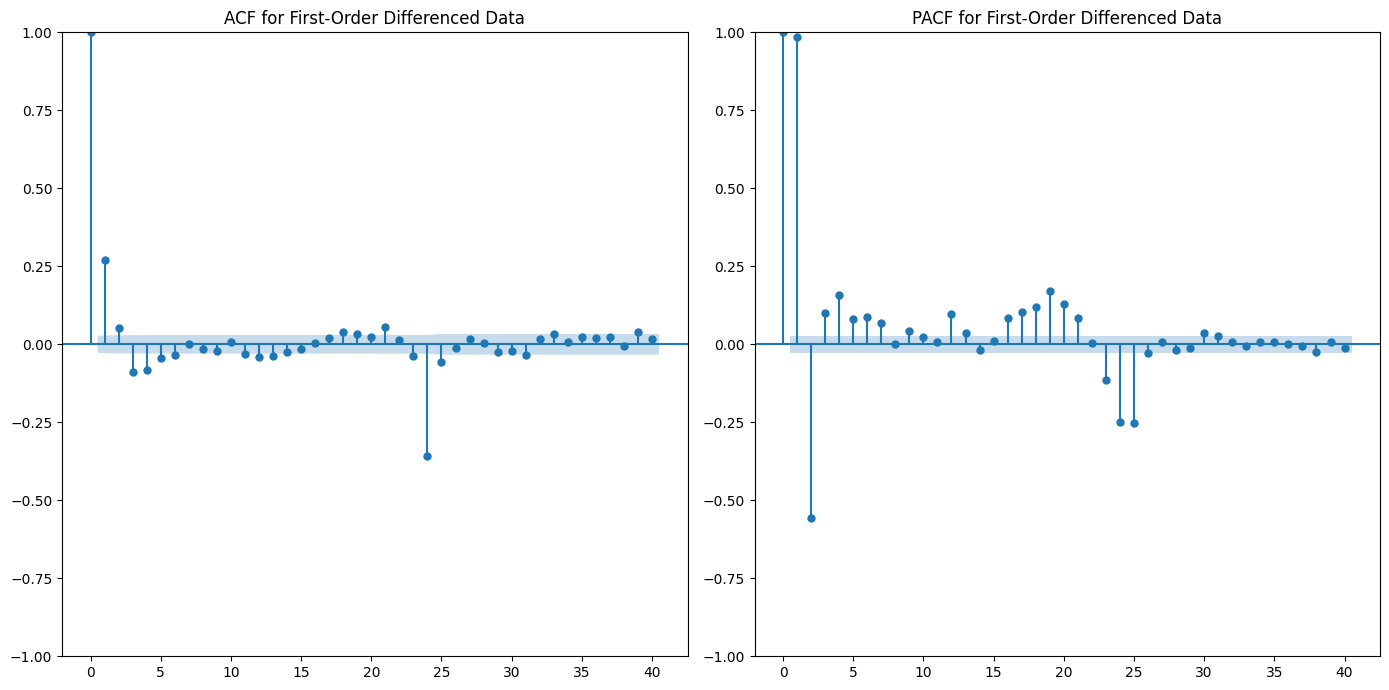

In [65]:
# Plot ACF and PACF for first-order differenced data
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(df["System Price"].diff().diff(24).dropna(), ax=plt.gca(), lags=40, title='ACF for First-Order Differenced Data')
plt.subplot(122)
plot_pacf(df["System Price"], ax=plt.gca(), lags=40, title='PACF for First-Order Differenced Data')
plt.tight_layout()
plt.show()

## Tuning

In [84]:
import pandas as pd
import numpy as np
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler


df = pd.read_excel('Complete Data FINAL.xlsx')  
df.set_index("DateTime", inplace=True)

df = df["2023-01-01":"2023-12-31"]


# Standardize the data
scaler = StandardScaler()
df['System Price'] = scaler.fit_transform(df[['System Price']])


data = df['System Price']

# Split into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Define the p, d, and q ranges
p = d = q = range(0, 5)
pdq = list(product(p, d, q))


results = []


for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        aic = model_fit.aic
        results.append({'p': param[0], 'd': param[1], 'q': param[2], 'AIC': aic})
    except Exception as e:
        print(f"Error with parameters {param}: {e}")
        continue

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)


best_params = results_df.loc[results_df['AIC'].idxmin()]
print("Best Parameters:")
print(best_params)


best_p = int(best_params['p'])
best_d = int(best_params['d'])
best_q = int(best_params['q'])


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\s

Best Parameters:
p         2.000000
d         1.000000
q         2.000000
AIC   -9371.123131
Name: 23, dtype: float64


c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# SARIMA 

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 3.147


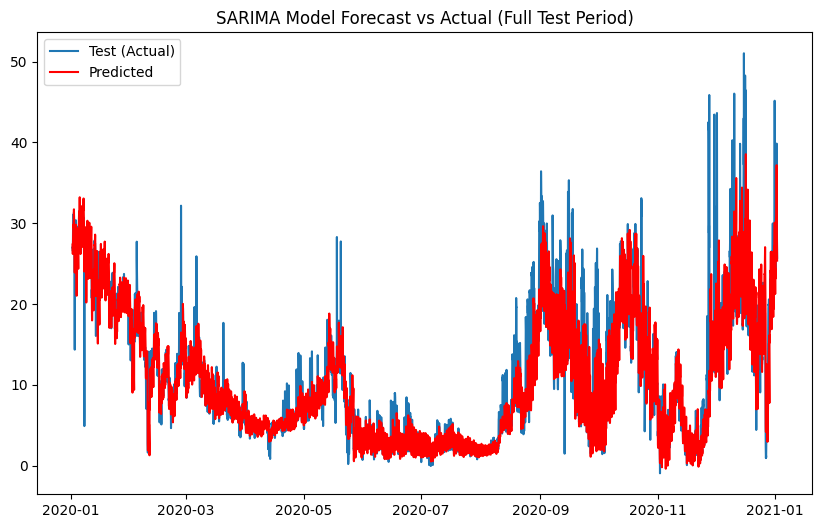

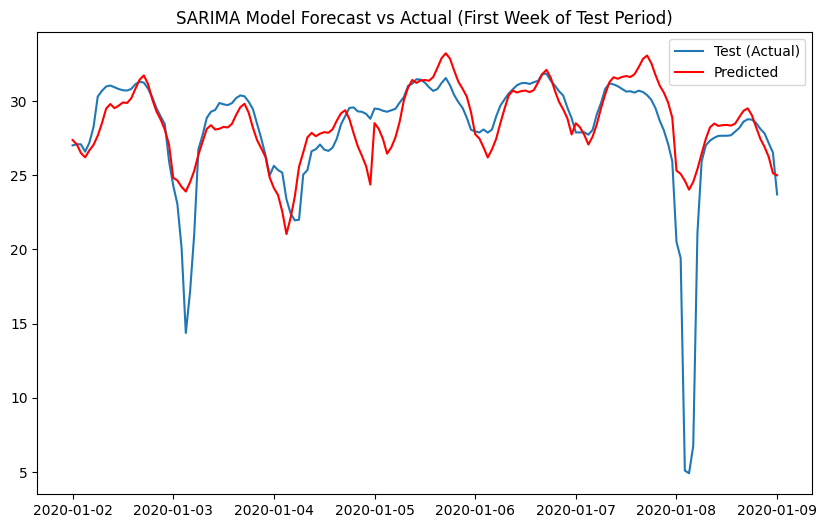

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox


df = pd.read_excel("C:\\Users\\mathi\\Downloads\\Final_Data_with_2024.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index("DateTime", inplace=True)
df = df.asfreq('H')
df.ffill(inplace=True)  # Forward fill to handle NaN values

df = df[["System Price"]]
# Define training and testing periods
train_start, train_end = '2023-01-01', '2023-12-31'
test_start, test_end = '2024-01-01', '2024-05-31'

train = df[train_start:train_end].copy()
test = df[test_start:test_end].copy()

# Apply Box-Cox transformation
shift = 43  # Ensure all data is positive
train['System Price'] += shift
test['System Price'] += shift

train['Transformed'], lam = boxcox(train['System Price'])
test['Transformed'] = boxcox(test['System Price'], lmbda=lam)


window_size = 8760  
retrain_interval = 1  # Retrain every 24 hours

# Walk-forward validation with 24-hour-ahead predictions
history = train['Transformed'].copy()
predictions = []

for i in range(0, len(test), 24):
    if i % retrain_interval == 0:
        # Use only the most recent 'window_size' observations for training
        if len(history) > window_size:
            history = history[-window_size:]
        model = SARIMAX(history, order=(2, 1, 0), seasonal_order=(1, 1, 1, 24), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

    # Forecast the next 24 hours
    forecast = model_fit.forecast(steps=24)
    predictions.extend(forecast)

    # Use the actual next 24 hours as input for the next prediction
    if i + 24 < len(test):
        actual_values = test['Transformed'].iloc[i:i+24]
        history = pd.concat([history, actual_values])

# Inverse transform and evaluate forecasts
predictions_array = inv_boxcox(np.array(predictions), lam) - shift
test_actuals_array = inv_boxcox(np.array(test['Transformed']), lam) - shift
rmse = sqrt(mean_squared_error(test_actuals_array[:len(predictions_array)], predictions_array))
print('Test RMSE: %.3f' % rmse)


plt.figure(figsize=(10, 6))
plt.plot(test.index, test_actuals_array, label='Test (Actual)')
plt.plot(test.index, predictions_array, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('SARIMA Model Forecast vs Actual (Full Test Period)')
plt.show()

# First Week of Test Period
one_week_test_start = test.index[0]
one_week_test_end = one_week_test_start + pd.Timedelta(days=7)
one_week_test = test.loc[one_week_test_start:one_week_test_end]
one_week_predictions = predictions_array[:len(one_week_test)]

plt.figure(figsize=(10, 6))
plt.plot(one_week_test.index, test_actuals_array[:len(one_week_test)], label='Test (Actual)')
plt.plot(one_week_test.index, one_week_predictions, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('SARIMA Model Forecast vs Actual (First Week of Test Period)')
plt.show()


Autocorrelation

In [3]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox



ljung_box_result = acorr_ljungbox(residuals, lags=[24], return_df=True)
print(ljung_box_result)


dw_stat = durbin_watson(residuals)
print('Durbin-Watson statistic:', dw_stat)

# Interpretation
if dw_stat < 1.5:
    interpretation = "The Durbin-Watson statistic is less than 1.5, indicating positive autocorrelation in the residuals."
elif dw_stat > 2.5:
    interpretation = "The Durbin-Watson statistic is greater than 2.5, indicating negative autocorrelation in the residuals."
else:
    interpretation = "The Durbin-Watson statistic is between 1.5 and 2.5, indicating no significant autocorrelation in the residuals."
print(interpretation)


bg_test = acorr_breusch_godfrey(model_fit, nlags=12)
print('Breusch-Godfrey test statistic:', bg_test[0])
print('Breusch-Godfrey p-value:', bg_test[1])

# Interpretation
if bg_test[1] < 0.05:
    interpretation = "The Breusch-Godfrey test p-value is less than 0.05, indicating the presence of autocorrelation in the residuals at the specified lags."
else:
    interpretation = "The Breusch-Godfrey test p-value is greater than 0.05, indicating no significant autocorrelation in the residuals at the specified lags."
print(interpretation)


NameError: name 'residuals' is not defined

Residual Analysis

In [6]:
# Residual Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'residuals' is obtained from your SARIMA model fit
# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from SARIMA Model')
plt.show()

# Summary statistics of residuals
print(residuals.describe())

# Residuals ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot for residuals
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()


NameError: name 'residuals' is not defined

<Figure size 1000x600 with 0 Axes>

Model diagnostics

                                     SARIMAX Results                                      
Dep. Variable:                        Transformed   No. Observations:                 8760
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 24)   Log Likelihood               -1412.565
Date:                            Sat, 15 Jun 2024   AIC                           2839.129
Time:                                    12:06:49   BIC                           2888.615
Sample:                                06-01-2023   HQIC                          2855.998
                                     - 05-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2416      0.015     80.519      0.000       1.211       1.272
ar.L2         -0.3891      0.007   

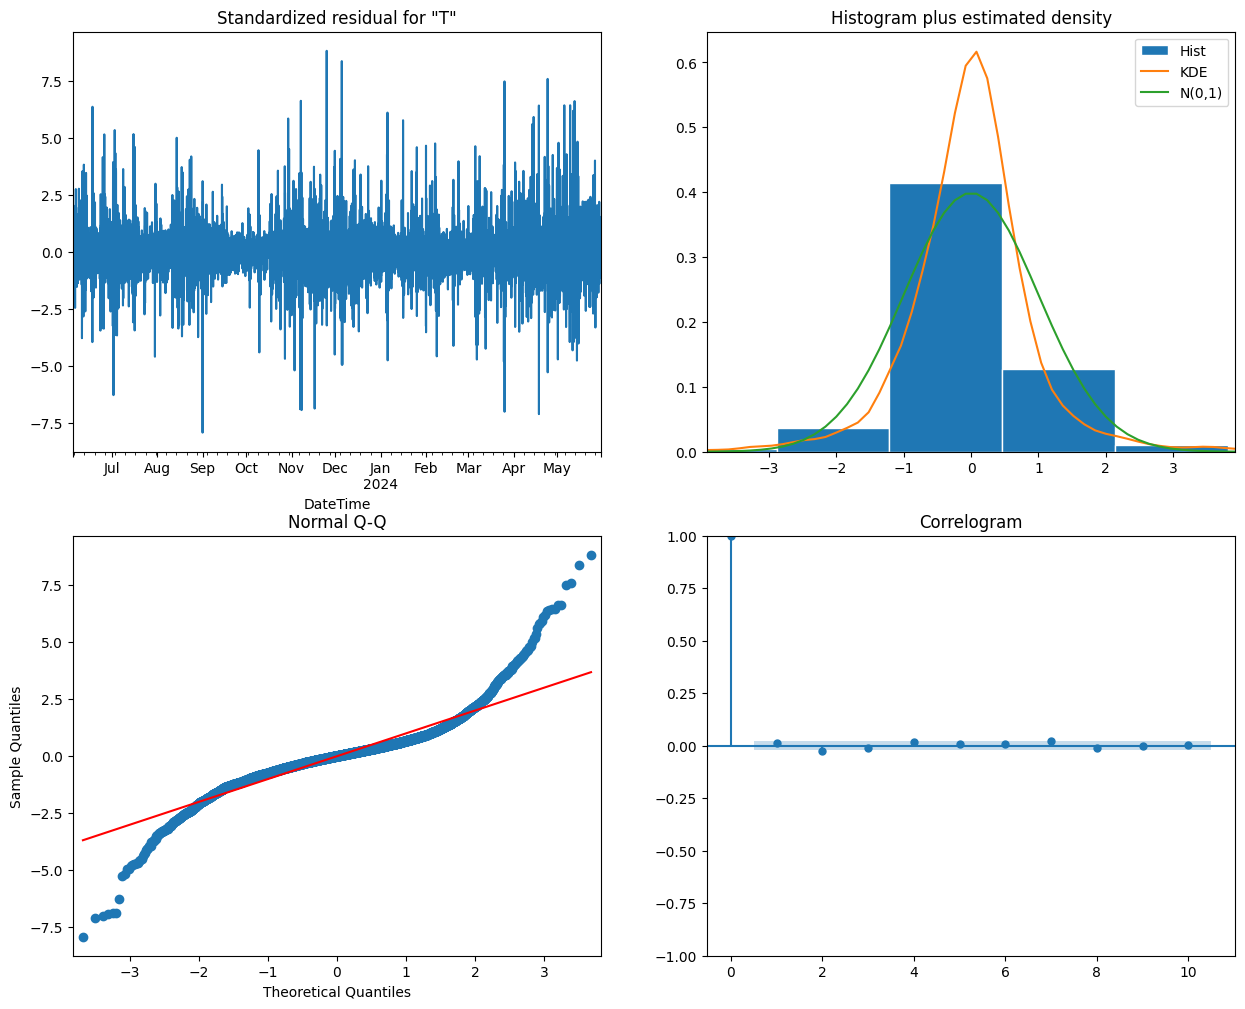

In [5]:
# Model Diagnostic Plots
print(model_fit.summary())

# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


# ARIMA

In [127]:

df = pd.read_excel("C:\\Users\\mathi\\Downloads\\Final_Data_with_2024.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index("DateTime", inplace=True)
df = df.asfreq('H')
df.ffill(inplace=True) 

In [128]:
df = df["2023-01-01":"2024-05-31"]

df["System Price"].min()

-29.868093

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

Test RMSE: 2.283


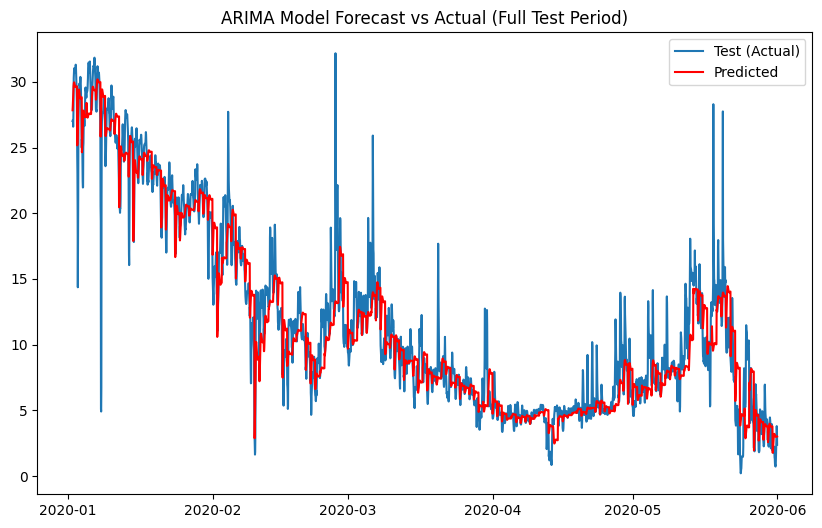

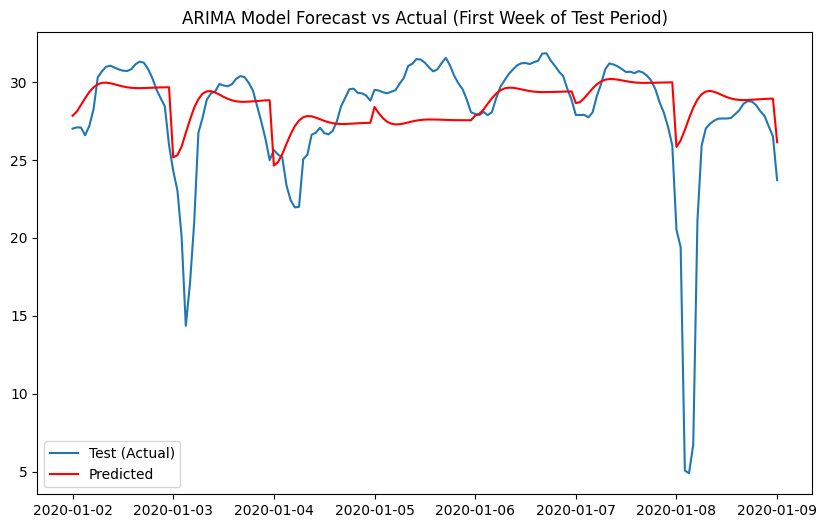

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox


df = pd.read_excel("C:\\Users\\mathi\\Downloads\\Final_Data_with_2024.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index("DateTime", inplace=True)
df = df.asfreq('H')
df.ffill(inplace=True)  # Forward fill to handle NaN values

df = df[["System Price"]]

train_start, train_end = '2023-01-01', '2023-12-31'
test_start, test_end = '2024-01-01', '2024-05-31'

train = df[train_start:train_end].copy()
test = df[test_start:test_end].copy()

# Apply Box-Cox transformation
shift = 30 # Ensure all data is positive
train['System Price'] += shift
test['System Price'] += shift

train['Transformed'], lam = boxcox(train['System Price'])
test['Transformed'] = boxcox(test['System Price'], lmbda=lam)

# Parameters for the moving window and retraining
window_size = 8760  
retrain_interval = 1  

# Walk-forward validation with 24-hour-ahead predictions
history = train['Transformed'].copy()
predictions = []

for i in range(0, len(test), 24):
    if i % retrain_interval == 0:
        # Use only the most recent 'window_size' observations for training
        if len(history) > window_size:
            history = history[-window_size:]
        model = ARIMA(history, order=(5, 1, 2))
        model_fit = model.fit()

    # Forecast the next 24 hours
    forecast = model_fit.forecast(steps=24)
    predictions.extend(forecast)

    # Use the actual next 24 hours as input for the next prediction
    if i + 24 < len(test):
        actual_values = test['Transformed'].iloc[i:i+24]
        history = pd.concat([history, actual_values])

# Inverse transform and evaluate forecasts
predictions_array = inv_boxcox(np.array(predictions), lam) - shift
test_actuals_array = inv_boxcox(np.array(test['Transformed']), lam) - shift

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_actuals_array[:len(predictions_array)], predictions_array))
print('Test RMSE: %.3f' % rmse)

# Visualization
# Full Test Period
plt.figure(figsize=(10, 6))
plt.plot(test.index, test_actuals_array, label='Test (Actual)')
plt.plot(test.index, predictions_array, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model Forecast vs Actual (Full Test Period)')
plt.show()

# First Week of Test Period
one_week_test_start = test.index[0]
one_week_test_end = one_week_test_start + pd.Timedelta(days=7)
one_week_test = test.loc[one_week_test_start:one_week_test_end]
one_week_predictions = predictions_array[:len(one_week_test)]

plt.figure(figsize=(10, 6))
plt.plot(one_week_test.index, test_actuals_array[:len(one_week_test)], label='Test (Actual)')
plt.plot(one_week_test.index, one_week_predictions, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model Forecast vs Actual (First Week of Test Period)')
plt.show()


In [115]:
# Save predictions to a DataFrame
predictions_df = pd.DataFrame({
    'DateTime': test.index[:len(predictions_array)],
    'Actual': test_actuals_array[:len(predictions_array)],
    'Predicted': predictions_array
})
predictions_df.set_index('DateTime', inplace=True)


predictions_df.to_csv('arima212predictions17.152.csv')

## Ljungbox Test for Autocorrelation in Residuals

In [170]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_result = acorr_ljungbox(residuals, lags=[24], return_df=True)
print(ljung_box_result)


       lb_stat      lb_pvalue
24  1278.66225  4.086714e-255


## Residual Analysis

In [172]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print('Durbin-Watson statistic:', dw_stat)

# Interpretation
if dw_stat < 1.5:
    interpretation = "The Durbin-Watson statistic is less than 1.5, indicating positive autocorrelation in the residuals."
elif dw_stat > 2.5:
    interpretation = "The Durbin-Watson statistic is greater than 2.5, indicating negative autocorrelation in the residuals."
else:
    interpretation = "The Durbin-Watson statistic is between 1.5 and 2.5, indicating no significant autocorrelation in the residuals."
print(interpretation)


Durbin-Watson statistic: 1.9180565919098713
The Durbin-Watson statistic is between 1.5 and 2.5, indicating no significant autocorrelation in the residuals.


In [7]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
bg_test = acorr_breusch_godfrey(model_fit, nlags=12)
print('Breusch-Godfrey test statistic:', bg_test[0])
print('Breusch-Godfrey p-value:', bg_test[1])

# Interpretation
if bg_test[1] < 0.05:
    interpretation = "The Breusch-Godfrey test p-value is less than 0.05, indicating the presence of autocorrelation in the residuals at the specified lags."
else:
    interpretation = "The Breusch-Godfrey test p-value is greater than 0.05, indicating no significant autocorrelation in the residuals at the specified lags."
print(interpretation)


Breusch-Godfrey test statistic: 29.529819277927373
Breusch-Godfrey p-value: 0.0032850092820270378
The Breusch-Godfrey test p-value is less than 0.05, indicating the presence of autocorrelation in the residuals at the specified lags.


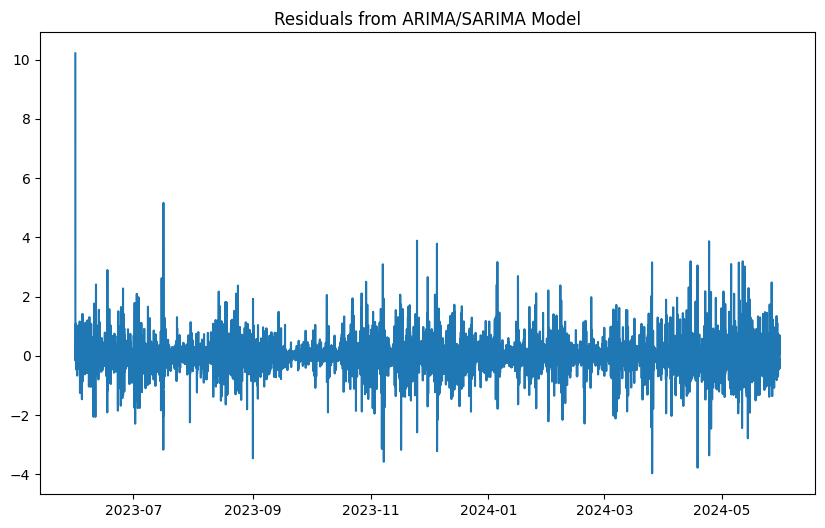

count    8760.000000
mean        0.001723
std         0.510464
min        -3.969826
25%        -0.209424
50%        -0.008971
75%         0.189338
max        10.216202
dtype: float64


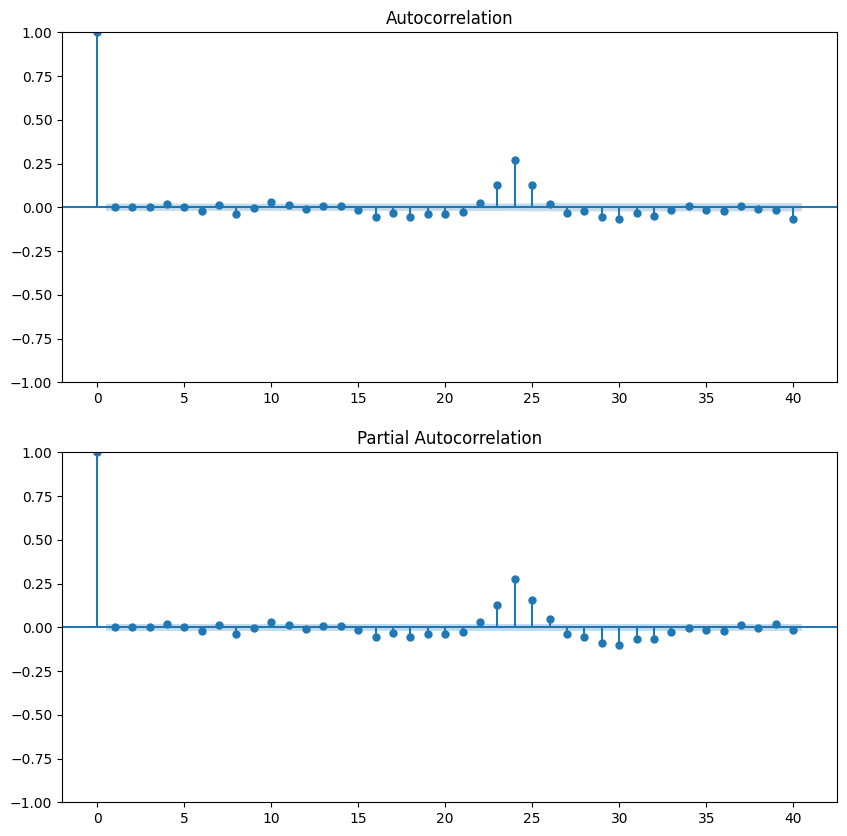

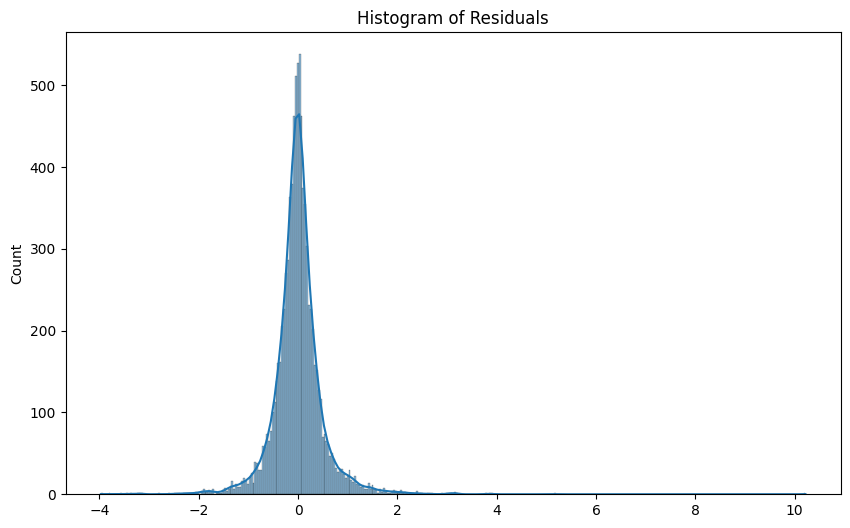

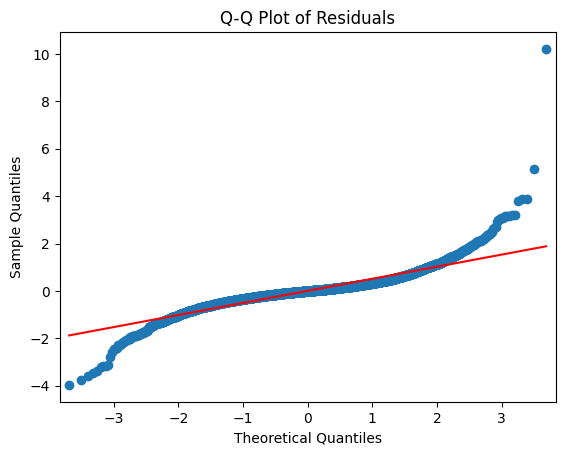

In [3]:

# Residual Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA/SARIMA Model')
plt.show()

# Summary statistics of residuals
print(residuals.describe())

# Residuals ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot for residuals
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()


                               SARIMAX Results                                
Dep. Variable:            Transformed   No. Observations:                 8760
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -20113.138
Date:                Thu, 13 Jun 2024   AIC                          40236.277
Time:                        21:48:28   BIC                          40271.666
Sample:                    06-01-2023   HQIC                         40248.335
                         - 05-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9725      0.031     31.738      0.000       0.912       1.033
ar.L2         -0.2782      0.023    -11.856      0.000      -0.324      -0.232
ma.L1         -0.6763      0.031    -21.890      0.0

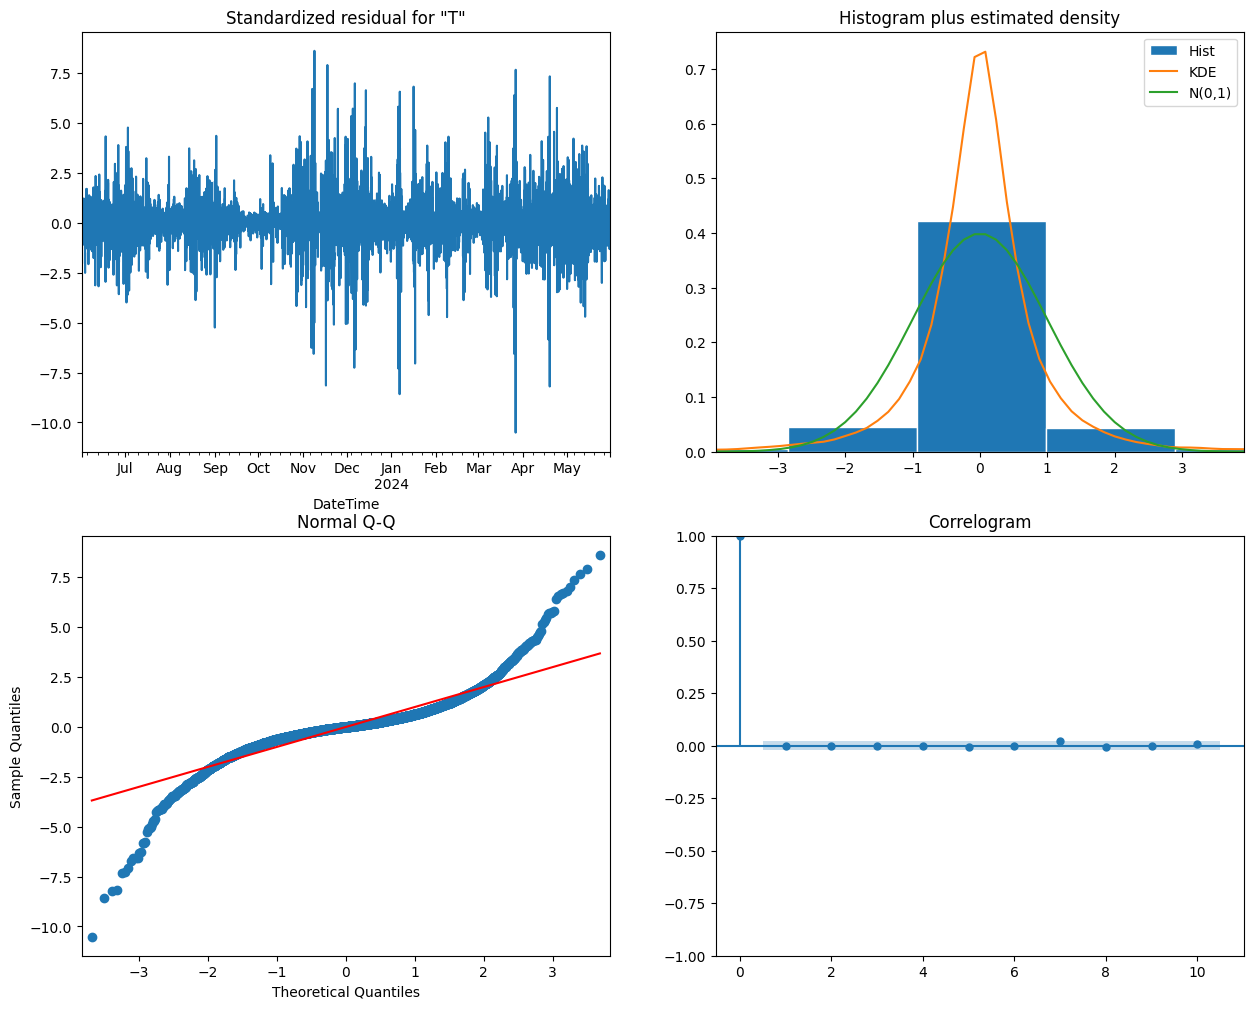

In [134]:
# Model Diagnostic Plots

print(model_fit.summary())

# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()



In [94]:
# Stationarity Tests
from statsmodels.tsa.stattools import adfuller, kpss

# Function to perform ADF test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    # Interpretation of results
    print("\nInterpretation:")
    if result[1] <= 0.05:
        print("The p-value is <= 0.05. Reject the null hypothesis. The data is stationary.")
    else:
        print("The p-value is > 0.05. Fail to reject the null hypothesis. The data is non-stationary.")

# Function to perform KPSS test
def kpss_test(timeseries):
    result = kpss(timeseries, regression='c')
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')
    
    # Interpretation of results
    print("\nInterpretation:")
    if result[1] > 0.05:
        print("The p-value is > 0.05. Fail to reject the null hypothesis. The data is stationary.")
    else:
        print("The p-value is <= 0.05. Reject the null hypothesis. The data is non-stationary.")

# Apply ADF test on the original time series data
print("ADF Test on Original Series:")
adf_test(df['System Price'])

# Apply KPSS test on the original time series data
print("\nKPSS Test on Original Series:")
kpss_test(df['System Price'])

# Apply ADF test on the differenced series (if the original series is not stationary)
df_diff = df['System Price'].diff().dropna()
print("\nADF Test on Differenced Series:")
adf_test(df_diff)

# Apply KPSS test on the differenced series (if the original series is not stationary)
print("\nKPSS Test on Differenced Series:")
kpss_test(df_diff)


ADF Test on Original Series:
ADF Statistic: -10.050731186907305
p-value: 1.4148630991154053e-17
Critical Values:
   1%: -3.4304667702263036
   5%: -2.861591610163819
   10%: -2.566797470362066

Interpretation:
The p-value is <= 0.05. Reject the null hypothesis. The data is stationary.

KPSS Test on Original Series:
KPSS Statistic: 7.644082299383106
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Interpretation:
The p-value is <= 0.05. Reject the null hypothesis. The data is non-stationary.

ADF Test on Differenced Series:


C:\Users\mathi\AppData\Local\Temp\ipykernel_24956\2956081296.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries, regression='c')


ADF Statistic: -40.365388533692176
p-value: 0.0
Critical Values:
   1%: -3.43046677231147
   5%: -2.861591611085404
   10%: -2.5667974708525976

Interpretation:
The p-value is <= 0.05. Reject the null hypothesis. The data is stationary.

KPSS Test on Differenced Series:
KPSS Statistic: 0.013005701215711733
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

Interpretation:
The p-value is > 0.05. Fail to reject the null hypothesis. The data is stationary.


C:\Users\mathi\AppData\Local\Temp\ipykernel_24956\2956081296.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c')
